Lindsey Engel - lindseye@stanford.edu
CS 41 Final Project
March 8, 2020

#####################################################
Combined gas -turbine and steam turbine cycle process: 

gas side cycle : compressor -> combustor -> turbine -> heat exchanger 

steam side cycle: cold storage - > pump -> heat exchanger -> turbine -> condenser -> pump


# Gas cycle: 

1a) engineering air at 25 C and 1 atmosphere 

1f) Natural gas at 25 C and 1 atmosphere is compressed to 20* P1f

2a) engingeering air is compressed to 10* P1a in a compressor with a given polytropic efficiency

2f) natural gas is compressed to 20* P1f in a compressor with a given polytropic efficiency 

3) The natural gas and engineering air is mixed (the ratio of natural gas to engineering air is unknown, 
and is constrained by the exit temperature of the combustor/ inlet temperature of the turbine  = 1410 K). 

4) the air / gas mix has been combusted under adiabatic and isobaric conditions with
the exit temeperature maximized to be 1410 K. This is an implicit solution since exit 
temperature can only be solved for by specifying the air to fuel ratio.

5) the combusted gas is now very hot and at a very high temperature, so we will 
extract work out of our gas by running it through a turbine with a given polytropic efficiency 

6-8) the (still) hot gas is sent through a heat exchanger where it will transfer heat to the 


# Steam Cycle:

w1) liquid water exists at 25 c and 1 atm

w2) liquid water is pumped up to an unknown pressure

w3-w5) liquid water enters the heat exchanger (HRSG) and exits as a superheated vapor

 w6) super heated seam enters a steam turbine and exits as a saturated liquid vapor mixture with an 88% quality
 
 w7) saturated liquid vapor mix is sent through a condenser exits as liquid water
 
 w8) liquid water at a low pressure is sent through a pump to increase the pressure and temperature to get back
 to atmospheric conditions



In [1]:
import numpy as np 
import cantera as ct
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# set up a way to store thermodynamic property values
class states:
	def __init__(self,temperature,pressure, enthalpy, entropy, moleFractions):
		self.T = temperature
		self.P = pressure
		self.h = enthalpy
		self.s = entropy
		self.x = moleFractions


In [3]:
# set up the gas object
def initializeGas():
	gas = ct.Solution('gri30.xml')
	return gas

In [4]:
def polytropicEfficiency(gas, state , state2, PR,polytropicEff,nSteps,type):
    s1 = state.s 
    h1 = state.h
    P = state.P 
    e = polytropicEff


    #compressor
    if type.lower() == 'compressor':
        state2.P = P*PR
        step = int((state2.P - P )/nSteps)
        P_vect = np.linspace(P,state2.P,nSteps)

        for i in range(len(P_vect)-1): #compressor eff = isentropic 2s-1 / actual 2
            P2 = P_vect[i+1]      
            gas.SP = s1, P2 
            h2s = gas.enthalpy_mass
            h2 = h1 + (1/e)*(h2s - h1)
        
            gas.HP = h2, P2 
            s2 = gas.entropy_mass
        
            s1 = s2 #now update for the next iteration
            h1 = h2
        
        state2.T = gas.T #temperature(gas);
        state2.h = h2
        state2.s = gas.entropy_mass # entropy_mass(gas);
    
    # turbine
    elif type.lower() == 'turbine':
        state2.P = P/PR
        gas.HP = h1 , P 
        s1 = gas.entropy_mass
        P_vect = np.linspace(P,state2.P,nSteps)
        for i in range(len(P_vect)-1): #turbine eff = actual 1-2 / isentropic 1-2s
            P2 = P_vect[i+1]
            gas.SP = s1, P2 
            h2s = gas.enthalpy_mass
            h2 = h1 - e*(h1 - h2s)
        
            gas.HP = h2, P2 #set(gas,'P',P2,'H',h2)
            s2 = gas.entropy_mass
        
            s1 = s2 #now update for the next iteration
            h1 = h2

        state2.T = gas.T #temperature(gas);
        state2.h = h2
        state2.s = gas.entropy_mass
    
    return state2


In [5]:
def getInletTemp(water,Pin,Pout,efficiency,steamQuality, nSteps):

	Prange = np.linspace(Pin,Pout,nSteps)

	Tlow = 500 
	Thigh = 1000
	steamQualityGuess = 1;
	diff = steamQuality- steamQualityGuess

	while abs(diff) > 0.005:
		Tguess = (Tlow+ Thigh)/2
		water.TP = Tguess, Pin
		s = water.entropy_mass
		h = water.enthalpy_mass

		i = 0
		for i in range(0,nSteps-1): 
			Pnext = Prange[i+1]
			water.SP = s,Pnext
			hs  = water.enthalpy_mass
			hnext = h-efficiency*(h-hs)

			water.HP = hnext , Pnext
			snext = water.s
			steamQualityGuess = water.X
			#print(water.X)

			s = snext
			h = hnext
			

		diff = steamQuality - steamQualityGuess
		#print(diff)
		#print(Tguess)
		if diff > 0 : 
			Tlow = Tguess
			#print(Tlow)
		else:
			Thigh = Tguess
			#print(Thigh)

	return Tguess


In [6]:
# Constants, givens, and set up
nSteps = 10
PR = 12.2 #pressure ratio
effComp = .86 #polytropic efficiency of compressor
effTurb = 0.82 #polytropic efficiency of turbine
effComb = 0.95 # 5 percent stagnation pressure loss accross combustor
lhv =  46e6 # lower heating value J/kg 
    
## Set up Fuel and Air chemistry
#mole fractions Fuel (Natural Gas Composition)
moleFractFuel = {'CH4':0.907,'C2H6':0.036,'C3H8':0.019,'CO2':0.01,'N2':0.018,'O2':0.01} 
# mole Fractions Air (dry engineering air)
moleFractAir = {'N2': 0.79,'O2':0.21}
# molecular weights 
MW = {'air':28.97 *10**-3,'CH4':16.04*10**-3,'C2H6':16.04*10**-3,\
'C3H8':44.1*10**-3,'N2':28*10**-3,'O2':2*15.99*10**-3,'CO2':44.01*10**-3} # kg/mol

# initialize the known states and leave unknown values empty
state1a = states(25+273,101325,[],[],moleFractAir) #before compression air
state1f = states(25+273,101325,[],[],moleFractFuel) # before compression fuel
state2a = states([], state1a.P*PR,[],[],moleFractAir) # after compression air
state2f = states([],state1f.P*PR*2,[],[],moleFractFuel) # after compression air
state2mix = states([],[],[],[],[]) # mix fuel and air 
state3 = states(1410,[],[],[],[]) # after combustion gas
state4 = states([],[],[],[],[]) # after turbine expansion 
state5 = states([],[],[],[],[])
state6 = states([],[],[],[],[])
state7 = states([],[],[],[],[])


In [7]:
# Walk through Gas turbine process

# set up the gas object
gas = initializeGas()
nsp = gas.n_species
iH2O = gas.species_index('H2O')
iO2 = gas.species_index('O2')
iN2 = gas.species_index('N2')
iCH4 = gas.species_index('CH4')
iC3H8 = gas.species_index('C3H8')
iC2H6 = gas.species_index('C2H6')
iCO2 = gas.species_index('CO2')

mair = 144 # kg/ s - known value

# compression - Air
# set temperature, pressure, and mole fractions
gas.TPX = state1a.T, state1a.P, state1a.x # set temperature pressure mole fractions
state1a.h = gas.h # get enthalpy
state1a.s = gas.s # get entropy
state1a.x = gas.X # get the whole vector, not a dict of particular species

state2a = polytropicEfficiency(gas, state1a, state2a, PR, effComp,nSteps,'Compressor')
wCompAir = state2a.h - state1a.h

# compression - fuel
gas.TPX = state1f.T, state1f.P, state1f.x # set temp, pressure, mole fractions
state1f.h = gas.h # get enthalpy
state1f.s = gas.s # get entropy
state1f.x = gas.X # get the whole vector, not a dict of particular species as passed in
MW['fuel'] = gas.mean_molecular_weight

state2f = polytropicEfficiency(gas,state1f, state2f, PR*2, effComp, nSteps,'Compressor')
state3.P = state2a.P * effComb

wCompFuel = state2f.h - state1f.h 


In [8]:
### Now, we want to iterate through phi (equivalence ratio) until we get the amount of fuel 
# corresponding to the combustor exit temperature that we are restricted to
nfuelMin = 100 # equivalence ratio (will vary between 0 and 1 with 1 being stoich and 0 being no fuel)
nfuelMax = 170 

nair = mair/MW.get('air')

err = 1000
print('Using bisection to converge to equivalence ratio to satisfy proper combustor exit temperature')
while abs(err)> 0.001*state3.T: # want to get within 0.1 percent of target temperature

	nfuelGuess = (nfuelMin + nfuelMax)/2
	# use phi to figure out how many moles of air we actually have.
	nactAir = nair
	mactAir = mair

	#need to reestablish what the new mole fractions are
	state2mix.x = nactAir*state1a.x + nfuelGuess*state1f.x 
    	
	#We know that we have 1 mole of fuel, so figure out what that is in mass, and figure
	# out the mass of air. 
	mfuel = nfuelGuess * MW.get('fuel')/1e3 
	mtot = mactAir + mfuel
    
	# Multiply the mass specific enthalpies by the mass
	# of each component and add together to get the total enthalpy. Once we
	# have the total enthalpy, set mole fractions.
    	
	H_total = mactAir * state2a.h + mfuel*state2f.h
	h_total = H_total/mtot
    
	#Then, set the mole fractions and the mass specifc enthalpy.
	gas.HPX = h_total, state3.P,state2mix.x 
	state2mix.s = gas.entropy_mass # get mixed entropy
	state2mix.h = gas.enthalpy_mass # get mixed enthalpy
	state2mix.T = gas.T # get temperature of the mix
    
	# combust (equilibrate) it with the known exit pressure 
	gas.equilibrate('HP')
	Tguess = gas.T
	state3.x = gas.X
    
	err = Tguess- state3.T
	# use bisection to converge on an answer quickly
	if Tguess > state3.T:
		nfuelMax = nfuelGuess
	else:
		nfuelMin = nfuelGuess
    
nfuel = nfuelGuess
print('Converged to an equivalence ratio of: ' + str(nair/nfuelGuess))
print('Required Moles of Fuel: ' + str(nfuel) +' moles')

Using bisection to converge to equivalence ratio to satisfy proper combustor exit temperature
Converged to an equivalence ratio of: 30.61811312555586
Required Moles of Fuel: 162.34375 moles


In [9]:
# save important values and the rest of state 3 (post combustion)
mair = 144
mtot = mair + mfuel
state3.T = Tguess
state3.h = gas.enthalpy_mass
state3.s = gas.entropy_mass

# solve for state 4 after the turbine
state4 = polytropicEfficiency(gas,state3,state4,PR,effTurb,nSteps,'Turbine')
state4.h = gas.enthalpy_mass
state4.s = gas.entropy_mass

wturb = state3.h - state4.h # energy balance on the turbine to get work output 

# find extensive quantities 
WCompFuel = mfuel*wCompFuel
WCompAir = mair*wCompAir
WGasTurb = mtot*wturb 

WNet = WGasTurb - WCompFuel - WCompAir
WNetGas = WNet

# get semi extensive entropy values for plotting 
# state 1
s1a = (state1a.s* mair) / mfuel
s1f = state1f.s 

# state 2
s2a = (state2a.s*mair) / mfuel
s2f = (state2f.s)

# state 2 mix
s2mix = (state2mix.s*mtot) / mfuel

# state 3
s3 = (state3.s*mtot) / mfuel

# state 4
s4 = (state4.s*mtot)/ mfuel

# Get the lower heating value for efficiency calculations 
LHV = lhv*mfuel;

# combined Vector for plotting
sair = [s1a/1000, s2a/1000 ,s2mix/1000]
sfuel = [s1f/1000, s2f/1000 ,s2mix/1000]
smix = [s2mix/1000 ,s3/1000,s4/1000]
Tair = [state1a.T ,state2a.T ,state2mix.T]
Tfuel = [state1f.T ,state2f.T, state2mix.T]
Tmixshort = [state2mix.T ,state3.T ,state4.T]

print('Total Chemical Energy of Fuel in: ' + str(LHV) + ' J')
print('Net Power out of gas turbine: ' + str(WNetGas) + ' J')
print('Gas turbine efficiency: ' + str(100* WNetGas/LHV) + '%')

Total Chemical Energy of Fuel in: 132445036.71042502 J
Net Power out of gas turbine: 40678078.196592234 J
Gas turbine efficiency: 30.713176731212595%


Plot of temperature versus entropy on a fuel specific basis through gas turbine stages.


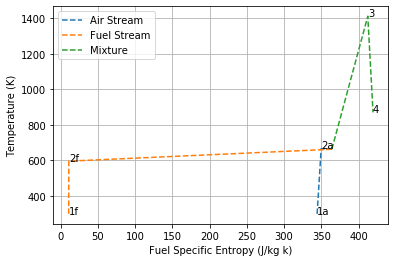

In [10]:
# plot different states on gas turbine side
airStation = ['1a','2a',' ']
fuelStation = ['1f','2f',' ']
mixStationShort = ['','3','4']
fig, ax = plt.subplots()
ax.plot(sair, Tair,'--')
ax.plot(sfuel,Tfuel,'--')
ax.plot(smix,Tmixshort,'--')
for i, txt in enumerate(airStation):
    ax.annotate(txt, (sair[i], Tair[i]))
for i, txt in enumerate(fuelStation):
    ax.annotate(txt, (sfuel[i], Tfuel[i]))
for i, txt in enumerate(mixStationShort):
    ax.annotate(txt, (smix[i],Tmixshort[i]))
ax.set(xlabel='Fuel Specific Entropy (J/kg k)', ylabel='Temperature (K)')
ax.grid()
ax.legend(['Air Stream', 'Fuel Stream', 'Mixture'])

#fig.savefig("test.png")
print('Plot of temperature versus entropy on a fuel specific basis through gas turbine stages.')
plt.show()

# Now do steam cycle analyis (whoo we're halfway there)


In [11]:
# Now do steam cycle analyis (whoo we're halfway there)
# set up water object and initialize states
# Constants for the water cycle
effHRSG = 0.9
mair = 144 # kg/s
Pcondenser = 6800 # Pa
PRCondenser = 0.92 # pressure drop across condenser
pinchDeltaT = 20 
effSteamTurbine = 0.75 # steam turbine efficiency
effPump = 0.85 # condensate and feed pump efficiciency
PRBoiler = 0.92 # economizer, boiler, and super heater pressure ratio
steamQuality = 0.88 # quality at exit of steam turbine

water = ct.Water()

# iniitialize water states
w1 = states(289, 101325,[],[],[])
w2 = states([],[],[],[],[])
w3 = states([],[],[],[],[])
w4 = states([],[],[],[],[])
w5 = states([],[],[],[],[])
w6 = states([],Pcondenser,[],[],steamQuality)
w7 = states([],[],[],[],[])
w8 = states([],[],[],[],[])

# Get some initial states that we don't have to iterate through

# cold storage
water.TP = w1.T , w1.P 
w1.h = water.enthalpy_mass

# state 6 (because we don't want to loop on stuff that we know for sure)
water.PX = w6.P , w6.x  
w6.T = water.T
w6.h = water.enthalpy_mass

In [12]:
#%% SOLVE FOR PRESSURE RATIO
# this loop finds the correct pressure ratio

#initalize some guesses and values
pumpPRlow = 115 #%115;%10;%50; %10.5;%1.1; % initalize pressure ratio
pumpPRhigh = 200
count = 0
percentDiff = 1; 

print('Using bisection to converge to a water pump pressure ratio.')
while True:

	#set state 1
	pumpPR = (pumpPRlow + pumpPRhigh)/2

	water.TP = w1.T, w1.P
	w1.s = water.entropy_mass
	w1.h = water.enthalpy_mass
	w2 = polytropicEfficiency(water,w1,w2, pumpPR,effPump,nSteps,'compressor')
	w2.P = w1.P*pumpPR

	# set state 2 (after pump)
	water.TP = w2.T, w2.P
	w2.h = water.enthalpy_mass

	# state 3 (after economizer)
	w3.P = w2.P*PRBoiler
	water.PX = w3.P , 0
	w3.T = water.T
	w3.h = water.enthalpy_mass

	# state 4 (after boiler)
	w4.P = w3.P*PRBoiler
	water.PX = w4.P , 1
	w4.T = water.T
	w4.h = water.enthalpy_mass

	# state 5 (after super heater)
	w5.P = w4.P*PRBoiler

	# effective pressure ratio of the turbine
	PRSteamTurbine = w5.P/w6.P

	# now we need to use the quality at stte 6 to get T5
	# run a polytropic efficiency in reverse to get state T5

	w5.T = getInletTemp(water,w5.P,w6.P,effSteamTurbine,steamQuality, nSteps)
	water.TP = w5.T, w5.P
	w5.h = water.enthalpy_mass

	# check effectiveness
	water.TP = state4.T, w5.P
	w5hmax = water.h # maximum value of enthalpy as determined by effectiveness
	w2hguess = (effHRSG* w5hmax - w5.h)/(effHRSG-1) # check value enthalpy to see if it matches with the effectivess

	diff = w2.h - w2hguess
	percentDiff = diff/w2.h

	if diff > 0: # then we need to increase pressure
		pumpPRlow = pumpPR #- 0.05* pumpPR
	else: 
		pumpPRhigh = pumpPR #+ 0.05 *pumpPR

	if abs(percentDiff) < 0.01: # want to be withing 1 percent
		break 

print('Converged to a pump pressure ratio of: '+ str(pumpPR))

Using bisection to converge to a water pump pressure ratio.
Converged to a pump pressure ratio of: 125.625


In [13]:
# SOLVE FOR mass flow rate of water
# now we have the proper pressure ratio, we want to use w5 to get our mdot value

qBoilSuper = w5.h - w3.h; # heat transfered from the super boiler
mtot = mair +mfuel
masslow = 15 
masshigh = 50
diff = 1
state6 = states([],[],[],[],[])

print('Using bisection to converge to a mass flow rate of water to satisfy heat exchanger pinch temperature.')
while abs(diff) > 0.001:
    
    massWater = (masshigh + masslow)/2
    #total heat transfer of water in boiling and superheat
    QBoilSuper = qBoilSuper*massWater
    
    #now on the gas side - solve for state 6
    #gas has superheated and boiled water
    state6.h = state4.h - (QBoilSuper/mtot)
    state6.P = state4.P
    gas.HP = state6.h, state6.P
    
    state6.T = gas.T

    #Calculate Tpinch
    Tpinch = state6.T - w3.T;
    
    diff = Tpinch - pinchDeltaT
    # tpinch and state6.T goes down with increasing mdot
    if diff > 0: # increase mdot
        masslow = massWater;
    else:
        masshigh = massWater;

print('Converged to a mass flow rate of water: ' + str(massWater) + ' kg/s')

Using bisection to converge to a mass flow rate of water to satisfy heat exchanger pinch temperature.
Converged to a mass flow rate of water: 23.65520477294922 kg/s


In [14]:
# get state 5, 7, and 8 of the gas
# state 5
Qsuper = (w5.h - w4.h)*massWater # heat gain across the super heater
state5.h = state4.h - (Qsuper/ mtot) 
state5.P = state4.P
gas.HP = state5.h, state5.P
state5.T = gas.T

# state 7 of gas
Qecon = (w3.h -w2.h)*massWater
state7.h = state6.h - (Qecon/mtot)
state7.P = state6.P
gas.HP = state7.h, state7.P
state7.T = gas.T

# state 7 of water 
w7.P = w6.P * PRCondenser
water.PX = w7.P, 0
w7.T = water.T
w7.h = water.enthalpy_mass
w7.s = water.entropy_mass
PRCondPump = w1.P/w7.P

water.PX = w7.P, 0
w8 = polytropicEfficiency(water,w7,w8, PRCondPump,effPump,nSteps,'compressor');


In [15]:
# Scale and renormalize values 
# Get specific enthalpy of the cycles scaled by their hottest/ most energetic state

hair = [(state1a.h*mair-state4.h*mtot)/(mfuel*1e6),\
        (state2a.h*mair-state4.h*mtot)/(mfuel*1e6),\
        (state2mix.h*mtot-state4.h*mtot)/(mfuel*1e6)]
hfuel = [(state1f.h*mfuel-state4.h*mtot)/(mfuel*1e6),\
         (state2f.h*mfuel-state4.h*mtot)/(mfuel*1e6),\
         (state2mix.h*mtot-state4.h*mtot)/(mfuel*1e6)]
hmix = [(state2mix.h*mtot-state4.h*mtot)/(mfuel*1e6),\
        (state3.h*mtot-state4.h*mtot)/(mfuel*1e6),\
        (state4.h*mtot-state4.h*mtot)/(mfuel*1e6),\
        (state5.h*mtot-state4.h*mtot)/(mfuel*1e6),\
        (state6.h*mtot-state4.h*mtot)/(mfuel*1e6),\
        (state7.h*mtot-state4.h*mtot)/(mfuel*1e6)]
Tmix = [state2mix.T,state3.T,state4.T,state5.T,state6.T,state7.T]
hwater= [(w1.h-w5.h)*(massWater/(mfuel*1e6)),\
          (w2.h-w5.h)*(massWater/(mfuel*1e6)),\
          (w3.h-w5.h)*(massWater/(mfuel*1e6)),\
          (w4.h-w5.h)*(massWater/(mfuel*1e6)),\
          (w5.h-w5.h)*(massWater/(mfuel*1e6)),\
          (w6.h-w5.h)*(massWater/(mfuel*1e6)),\
          (w7.h-w5.h)*(massWater/(mfuel*1e6)),\
          (w8.h-w5.h)*(massWater/(mfuel*1e6))]
         
Twater = [w1.T,w2.T,w3.T,w4.T,w5.T,w6.T,w7.T,w8.T]

In [16]:
# check work output
WTurb = massWater*(w5.h - w6.h)
WFeedPump = massWater*(w2.h - w1.h)
WCondPump = massWater*(w8.h - w7.h)
WNetWater = WTurb - (WFeedPump + WCondPump)

workOutput = WNetWater + WNetGas
gasTurbineEfficiency = WNetGas/LHV
steamTurbineEfficiency = WNetWater/LHV
combinedEfficiency = workOutput/LHV

# useful metrics of efficiency on a Lower heating value basis 
print('Gas Turbine Efficiency: ' + str(gasTurbineEfficiency*100) + '%')
print('Steam Turbine Efficiency: '+ str(steamTurbineEfficiency*100)+ '%')
print('Combined Cycle Efficiency: ' + str(combinedEfficiency*100)+'%')

Gas Turbine Efficiency: 30.713176731212595%
Steam Turbine Efficiency: 17.42097286118692%
Combined Cycle Efficiency: 48.13414959239951%


Plot of temperature versus enthalpy on a normalized fuel specific basis through gas cycle and steam cycle stages.


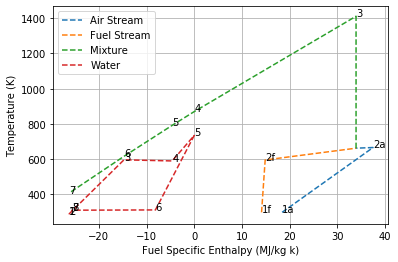

In [17]:
# plot different states on gas turbine side
mixStation = [' ','3','4','5','6','7']
waterStation = ['1','2','3','4','5','6','7','8']

fig, ax = plt.subplots()
ax.plot(hair, Tair,'--')
ax.plot(hfuel,Tfuel,'--')
ax.plot(hmix,Tmix,'--')
ax.plot(hwater,Twater,'--')
for i, txt in enumerate(airStation):
    ax.annotate(txt, (hair[i], Tair[i]))
for i, txt in enumerate(fuelStation):
    ax.annotate(txt, (hfuel[i], Tfuel[i]))
for i, txt in enumerate(mixStation):
    ax.annotate(txt, (hmix[i],Tmix[i]))
for i, txt in enumerate(waterStation):
    ax.annotate(txt,(hwater[i],Twater[i]))
    
ax.set(xlabel='Fuel Specific Enthalpy (MJ/kg k)', ylabel='Temperature (K)')
ax.grid()
ax.legend(['Air Stream', 'Fuel Stream', 'Mixture','Water'])

print('Plot of temperature versus enthalpy on a normalized fuel specific basis through gas cycle and steam cycle stages.')
plt.show()